# Digit recognizer with pytorch
https://www.kaggle.com/c/digit-recognizer/data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from time import time

%matplotlib inline
sns.set()

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader

## Import training data

In [2]:
df_train = pd.read_csv('train.csv',dtype = np.float32)
df_train.shape

(42000, 785)

In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: float32(785)
memory usage: 125.8 MB


In [4]:
X_numpy = df_train.loc[:,df_train.columns != "label"].values/255
X_numpy.shape

(42000, 784)

In [5]:
y_numpy = df_train.label.values
y_numpy.shape

(42000,)

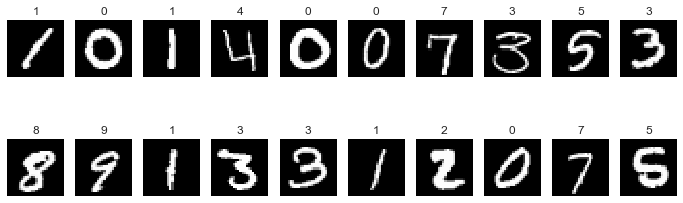

In [6]:
# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(12, 4))
plt.gray() 
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(X_numpy[idx].reshape(28,28)) 
    ax.set_title(int(y_numpy[idx]))
    ax.axis('off')

## Generate train and test data loaders

In [8]:
# Train / test split
X_train, X_test, y_train, y_test = train_test_split(X_numpy, y_numpy, test_size = 0.2, random_state = 42)

In [9]:
# batch_size, epoch and iteration
batch_size = 100
n_iters = 15000
num_epochs = int(n_iters / (len(X_train) / batch_size))
print('Number of epochs: {}'.format(num_epochs))

Number of epochs: 44


In [10]:
# numpy to torch tensors
X_train_tensor = torch.from_numpy(X_train)
y_train_tensor = torch.from_numpy(y_train).type(torch.LongTensor)

X_test_tensor = torch.from_numpy(X_test)
y_test_tensor = torch.from_numpy(y_test).type(torch.LongTensor)

# Pytorch train and test sets
train = torch.utils.data.TensorDataset(X_train_tensor,y_train_tensor)
test = torch.utils.data.TensorDataset(X_test_tensor,y_test_tensor)

# data loader
train_loader = DataLoader(train, batch_size = batch_size, shuffle = False)
test_loader = DataLoader(test, batch_size = batch_size, shuffle = False)

## Create neural net

In [11]:
# instantiate neural net
input_dim = 784
hidden_dim = 150 
output_dim = 10

# Create Model
class Model_nn(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Model_nn, self).__init__()
        # Linear function 1: 784 --> 150
        self.fc1 = nn.Linear(input_dim, hidden_dim) 
        self.relu1 = nn.ReLU()
        # Linear function 2: 150 --> 150
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.tanh2 = nn.Tanh()
        # Linear function 3: 150 --> 150
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.elu3 = nn.ELU()   
        # Linear function 4 (readout): 150 --> 10
        self.fc4 = nn.Linear(hidden_dim, output_dim)  
    
    def forward(self, x):
        # Linear function 1
        out = self.fc1(x)
        out = self.relu1(out)    
        # Linear function 2
        out = self.fc2(out)
        out = self.tanh2(out) 
        # Linear function 2
        out = self.fc3(out)
        out = self.elu3(out)        
        # Linear function 4
        out = self.fc4(out)
        return out

# Create Neural Net
model = Model_nn(input_dim, hidden_dim, output_dim)

# Cross Entropy Loss 
error = nn.CrossEntropyLoss()

# SGD Optimizer
learning_rate = 0.02
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

## Train neural net

In [12]:
# model training
count = 0
prev_accuracy = 0
loss_list = []
iteration_list = []
accuracy_list = []
t0 = time()

for epoch in range(num_epochs):
    
    for i, (images, labels) in enumerate(train_loader):
        
        train = Variable(images.view(-1, 784))
        labels = Variable(labels)
        
        # Clear gradients
        optimizer.zero_grad()
        
        # Forward propagation
        outputs = model(train)
        
        # Calculate cross entropy loss
        loss = error(outputs, labels)
        
        # Calculating gradients
        loss.backward()
        
        # Update parameters
        optimizer.step()
        
        # Update count
        count += 1
        
        # Store accuracy and loss
        if count % 50 == 0:
            
            # Calculate Accuracy         
            correct, total = 0, 0

            # Predict test dataset
            for images, labels in test_loader:

                test = Variable(images.view(-1, 784))
                
                # Forward propagation
                outputs = model(test)
                
                # Get predictions from the max value
                predicted = torch.max(outputs.data, 1)[1]
                
                # Total number of labels
                total += len(labels)

                # Total correct predictions
                correct += (predicted == labels).sum()
            
            # Calculate accuracy
            accuracy = 100 * correct / float(total)
           
            # store loss and iteration
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
    
    # Save model if accuracy has improved
    if accuracy > prev_accuracy:
        torch.save(model.state_dict(), 'best_nn.pth')
        save_status = 'model_saved'
    else:
        save_status =''
    prev_accuracy = accuracy
        
    # update time
    tx = round(time()-t0, 2)
    
    print('Epoch: {}/{}\tTime: {}s\tLoss: {:.4f}\tAccuracy: {:.2f} %\t{}'\
          .format(epoch+1, num_epochs, tx,loss.data, accuracy, save_status))

Epoch: 1/44	Time: 5.85s	Loss: 1.3138	Accuracy: 66.30 %	model_saved
Epoch: 2/44	Time: 12.11s	Loss: 0.4464	Accuracy: 83.93 %	model_saved
Epoch: 3/44	Time: 18.24s	Loss: 0.2838	Accuracy: 87.35 %	model_saved
Epoch: 4/44	Time: 23.8s	Loss: 0.2225	Accuracy: 89.13 %	model_saved
Epoch: 5/44	Time: 29.46s	Loss: 0.1921	Accuracy: 89.85 %	model_saved
Epoch: 6/44	Time: 35.06s	Loss: 0.1731	Accuracy: 90.58 %	model_saved
Epoch: 7/44	Time: 41.02s	Loss: 0.1564	Accuracy: 91.62 %	model_saved
Epoch: 8/44	Time: 46.87s	Loss: 0.1414	Accuracy: 92.20 %	model_saved
Epoch: 9/44	Time: 53.43s	Loss: 0.1269	Accuracy: 92.70 %	model_saved
Epoch: 10/44	Time: 60.78s	Loss: 0.1148	Accuracy: 93.19 %	model_saved
Epoch: 11/44	Time: 66.8s	Loss: 0.1035	Accuracy: 93.31 %	model_saved
Epoch: 12/44	Time: 73.14s	Loss: 0.0937	Accuracy: 94.04 %	model_saved
Epoch: 13/44	Time: 79.49s	Loss: 0.0850	Accuracy: 94.39 %	model_saved
Epoch: 14/44	Time: 85.81s	Loss: 0.0769	Accuracy: 94.42 %	model_saved
Epoch: 15/44	Time: 91.69s	Loss: 0.0705	Accurac

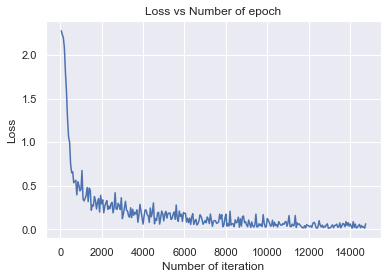

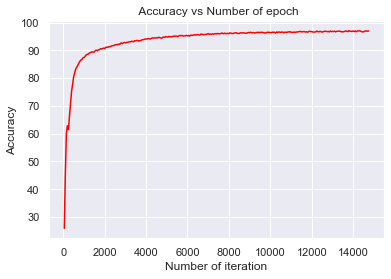

In [13]:
# visualization loss 
plt.plot(iteration_list,loss_list)
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("Loss vs Number of epoch")
plt.show()

# visualization accuracy 
plt.plot(iteration_list,accuracy_list,color = "red")
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.title(" Accuracy vs Number of epoch")
plt.show()

In [14]:
# Evaluate model on full test set
with torch.no_grad():
    test_predictions = model(X_test_tensor)
    _, y_test_predicted = torch.max(test_predictions.data, 1)
    
print(classification_report(y_test_tensor, y_test_predicted))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       816
           1       0.98      0.99      0.98       909
           2       0.98      0.96      0.97       846
           3       0.97      0.94      0.96       937
           4       0.97      0.97      0.97       839
           5       0.96      0.96      0.96       702
           6       0.96      0.98      0.97       785
           7       0.96      0.98      0.97       893
           8       0.97      0.96      0.96       835
           9       0.95      0.96      0.96       838

    accuracy                           0.97      8400
   macro avg       0.97      0.97      0.97      8400
weighted avg       0.97      0.97      0.97      8400



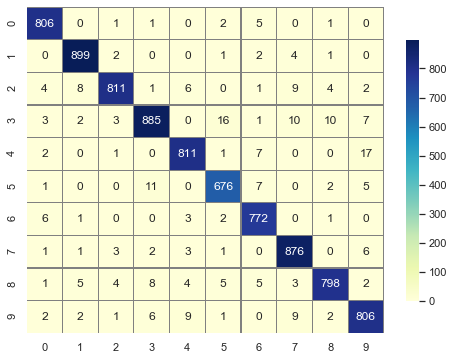

In [15]:
# Confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(
    confusion_matrix(y_test_tensor, y_test_predicted), 
    cmap='YlGnBu', 
    linewidths=.2,
    linecolor='gray',
    cbar_kws={"shrink": .8},
    annot = True,
    fmt='d'
)

## Load and test model

In [16]:
# Load model
loaded_model = Model_nn(input_dim, hidden_dim, output_dim)
loaded_model.load_state_dict(torch.load('best_nn.pth'))
loaded_model.eval()

Model_nn(
  (fc1): Linear(in_features=784, out_features=150, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=150, out_features=150, bias=True)
  (tanh2): Tanh()
  (fc3): Linear(in_features=150, out_features=150, bias=True)
  (elu3): ELU(alpha=1.0)
  (fc4): Linear(in_features=150, out_features=10, bias=True)
)

In [17]:
# Import test data
df_new = pd.read_csv('test.csv',dtype = np.float32)
df_new.shape

(28000, 784)

In [18]:
#X_new_numpy = df_new.loc[:,df_new.columns != "label"].values/255
X_new_numpy = df_new.loc[:].values/255
X_new_tensor = torch.from_numpy(X_new_numpy)

In [19]:
with torch.no_grad():
    result = loaded_model(X_new_tensor)
    _, new_predicted = torch.max(result.data, 1)

In [20]:
result.shape

torch.Size([28000, 10])

In [21]:
new_predicted.shape

torch.Size([28000])

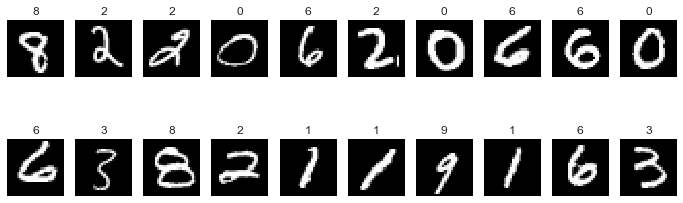

In [25]:
# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(12, 4))
plt.gray() 
# display 20 images
for idx, figx  in zip(np.random.randint(0, len(X_new_tensor)-1, size=20),np.arange(20)):    
    ax = fig.add_subplot(2, 20/2, figx+1, xticks=[], yticks=[])
    ax.imshow(X_new_numpy[idx].reshape(28,28)) 
    ax.set_title(new_predicted[idx].numpy())
    ax.axis('off')